In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from scipy import stats

In [14]:
df = pd.read_csv("Clean_Dataset.csv",index_col=0)
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [15]:
df.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [16]:
df.describe(include='all')

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
count,300153,300153,300153,300153,300153,300153,300153,300153,300153.000000,300153.000000,300153.000000
unique,6,1561,6,6,3,6,6,2,NaN,NaN,NaN
top,Vistara,UK-706,Delhi,Morning,one,Night,Mumbai,Economy,NaN,NaN,NaN
freq,127859,3235,61343,71146,250863,91538,59097,206666,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.221021,26.004751,20889.660523
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.191997,13.561004,22697.767366
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830000,1.000000,1105.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.830000,15.000000,4783.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.250000,26.000000,7425.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.170000,38.000000,42521.000000


*Data Visualization*

In [18]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type': 'xy'}]])

fig.add_trace(go.Pie(labels=df['airline'].unique(), values=df['airline'].value_counts(), name='airline', hole=0.5, textfont_size=20,
                     marker=dict(line=dict(color='black', width=2)), marker_colors=['gold', 'mediumturquoise','darkorange', 'lightgreen']), 1, 1)
fig.add_trace(go.Bar(x=df['airline'].unique(), y=df['airline'].value_counts(), name='Airline', text=df['airline'].value_counts(), 
                     marker_line_color='black', marker_line_width=2, marker_color='pink', showlegend=False),1, 2)

fig.update_layout(title_text='<b>Airline Distribution<b>')
fig.update_yaxes(title_text='Count', row=1, col=2)
fig.update_xaxes(title_text='Airline', row=1, col=2)

fig.show()

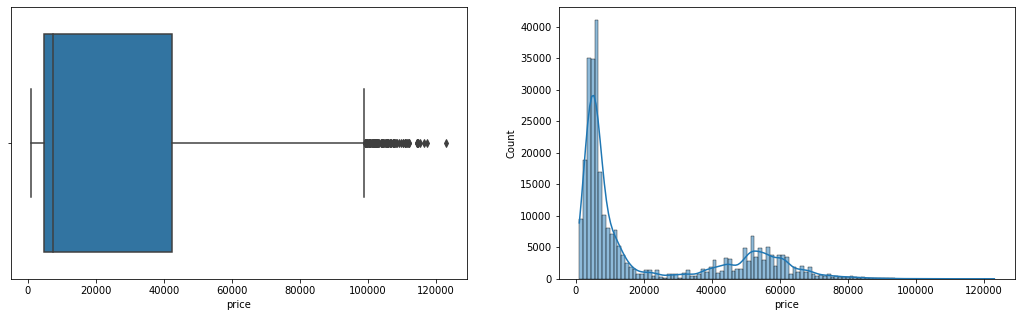

In [19]:
plt.figure(figsize = (18,5))
plt.subplot(1,2,2)
sns.histplot(x = 'price', data = df, kde = True)
plt.subplot(1,2,1)
sns.boxplot(x = 'price', data = df)

Text(0.5, 1.0, 'Airline prices based on companies for business tickets')

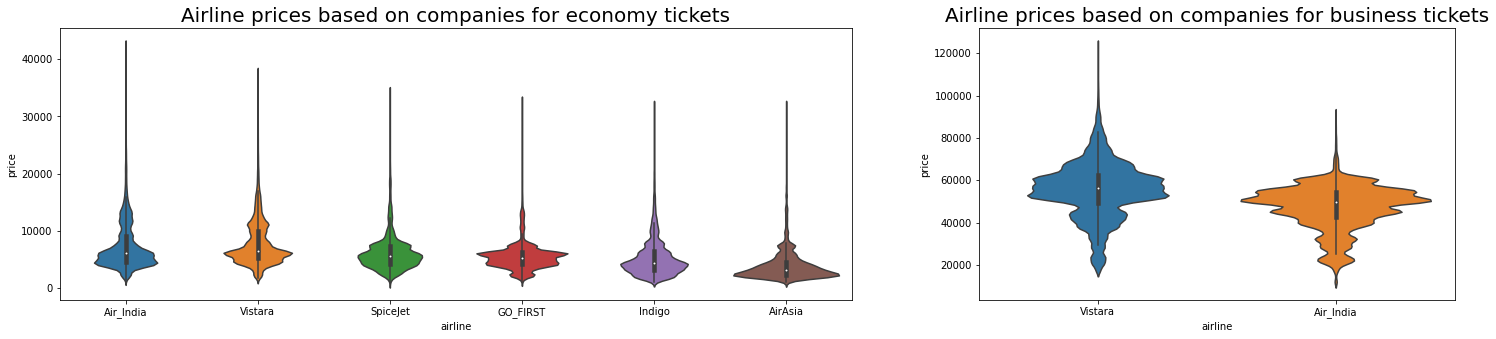

In [20]:
fig, axs = plt.subplots (1, 2, gridspec_kw={'width_ratios': [5, 3]}, figsize=(25, 5))
sns.violinplot(y = "price", x = "airline",data = df.loc[df["class"]=='Economy'].sort_values("price", ascending = False), kind="boxen", ax=axs[0])
axs[0].set_title("Airline prices based on companies for economy tickets",fontsize=20)
sns.violinplot(y = "price", x = "airline",data = df.loc[df["class"]=='Business'].sort_values("price", ascending = False), kind="boxen", ax=axs[1])
axs[1].set_title("Airline prices based on companies for business tickets",fontsize=20)

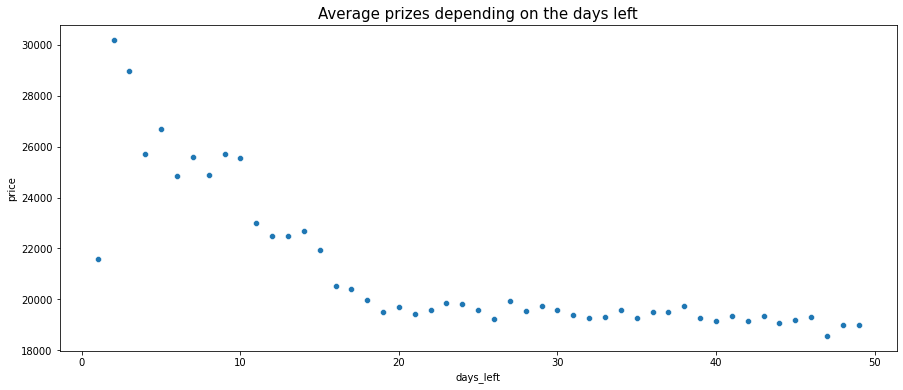

In [21]:
df_temp = df.groupby(['days_left'])['price'].mean().reset_index()

plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="days_left", y="price", data=df_temp).set_title("Average prizes depending on the days left",fontsize=15)

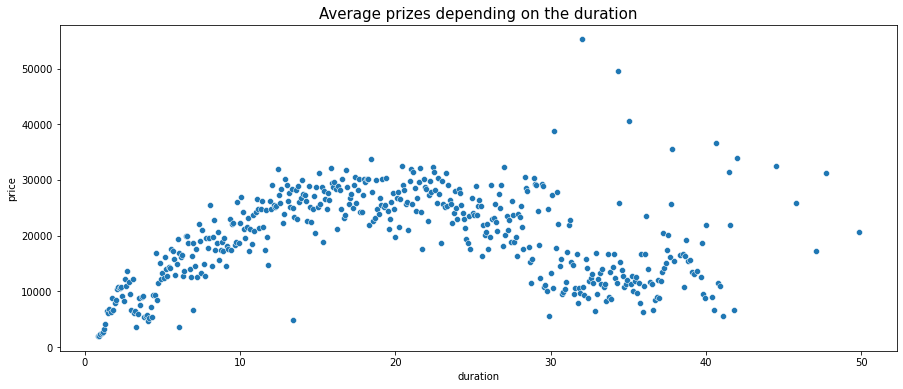

In [22]:
df_temp = df.groupby(['duration'])['price'].mean().reset_index()

plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="duration", y="price", data=df_temp).set_title("Average prizes depending on the duration",fontsize=15)


*Data Preprocessing*

In [23]:
def preprocessing(df):
    df["stops"] = df["stops"].replace({'zero':0,'one':1,'two_or_more':2}).astype(int)
    df["class"] = df["class"].replace({'Economy':0,'Business':1}).astype(int)
    
    dummies_variables = ["airline","source_city","destination_city","departure_time","arrival_time"]
    dummies = pd.get_dummies(df[dummies_variables], drop_first= True)
    df = pd.concat([df,dummies],axis=1)
    
    df = df.drop(["flight","airline","source_city","destination_city","departure_time","arrival_time"],axis=1)
    
    return df

In [24]:
df = pd.read_csv("Clean_Dataset.csv",index_col=0)
# Preprocessing the data
df = preprocessing(df)
X = df.copy()
y = X.pop("price")
    
xtrain,xtest,ytrain,ytest = train_test_split(X,y,random_state = 1,test_size=0.3, shuffle=True)

*Training Models*

In [25]:
models = {}

models["KNeighborsRegressor"]={"model":KNeighborsRegressor(n_neighbors=50)}
models["LinearRegression"]={"model":LinearRegression()}
models["XGBRegressor"]={"model":XGBRegressor(n_jobs=5,learning_rate=0.1,max_depth=10,random_state=1)}

In [26]:
def score_dataset(X, y, model=XGBRegressor()):
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    
    score_r2 = cross_val_score(model, X, y, cv=5, scoring="r2")
    score_r2 = score_r2.mean()
    
    return score_r2

In [56]:
def get_scores(models,xtrain,ytrain):
    for name,model in models.items():
        model["model"].fit(xtrain,ytrain)

        score_r2 = score_dataset(xtrain, ytrain, model=model["model"])
        score = {'model':"Linear regression", 'score_r2':score_r2}
        print("--- "+name+" ---")
        print("Score r2: {}".format(score_r2))
        print("\n")

In [57]:
get_scores(models,xtrain,ytrain)

--- KNeighborsRegressor ---
Score r2: 0.7091120580806901


--- LinearRegression ---
Score r2: 0.9095338142489373


[11:02:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:04:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:06:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:07:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--- XGBRegressor ---
Score r2: 0.9821663952552744




*Applying XGB regressor on test data*

In [46]:
import xgboost
classifier = xgboost.XGBRegressor()

In [47]:
params = { 
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]}

In [59]:
rs_model=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

In [49]:
#model fitting
rs_model.fit(X,y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan]



[10:43:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='roc_auc', verbose=3)

In [50]:
rs_model.best_estimator_

XGBRegressor(colsample_bytree=0.3, gamma=0.3, max_depth=12, min_child_weight=7)

In [65]:
model = xgboost.XGBRegressor(colsample_bytree=0.3, gamma=0.3, max_depth=12, min_child_weight=7)
model.fit(xtrain,ytrain)
ypred = model.predict(xtest)

[11:13:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


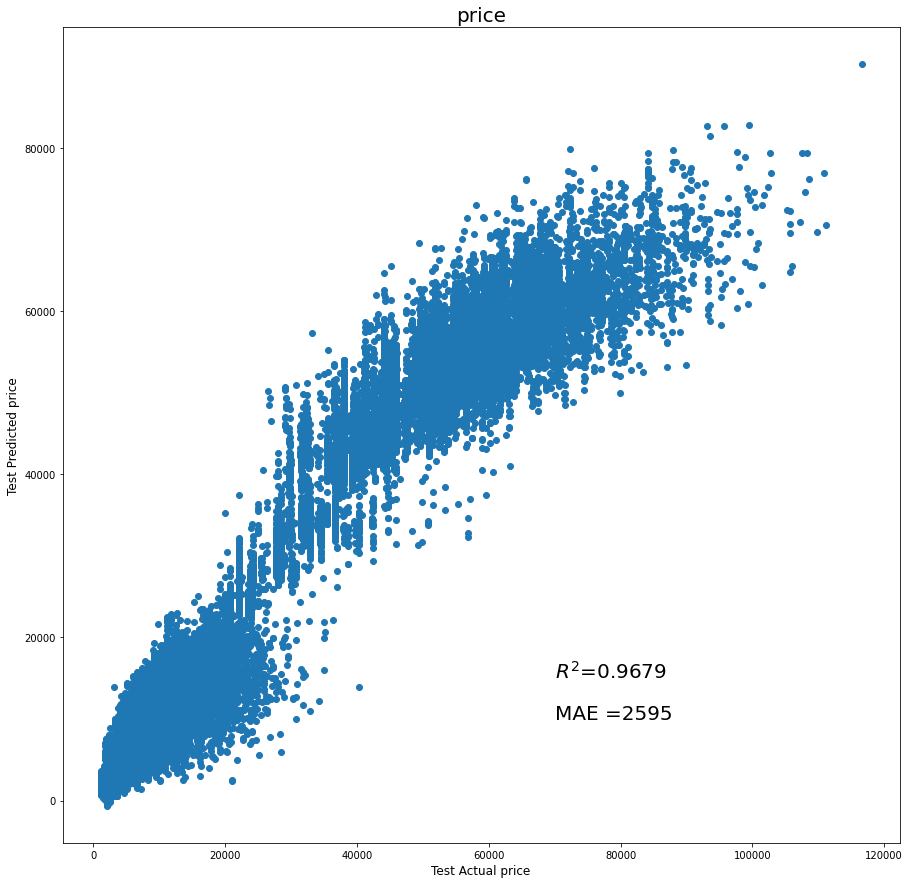

In [66]:
fig,ax = plt.subplots(figsize=(15,15))
ax.set_title("price",fontsize=20)
ax.set_ylabel('Test Predicted price',fontsize=12)
ax.set_xlabel('Test Actual price',fontsize=12)
ax.scatter(ytest,ypred)

score_r2 = r2_score(ytest, ypred) 
score_mae = mean_absolute_error(ytest, ypred)
plt.text(70000,15000,'$ R^{2} $=' + str(round(score_r2, 4)),fontsize=20)
plt.text(70000,10000,'MAE =' + str(round(score_mae)),fontsize=20)
plt.show()